In [247]:
import sys
import argparse
import csv
import math
import aubio
import numpy as np
import matplotlib.pyplot as plt

In [305]:
name = "slovak"

In [306]:
filename = "../samples/%s.wav" % name

In [307]:
SAMPLE_RATE = 44100
WINDOW_SIZE = 4096 # fft size
HOP_SIZE = 1024
TOLERANCE = 0.8
METHOD = 'yinfft'

In [308]:
pitches = []
s = aubio.source(filename, SAMPLE_RATE, HOP_SIZE)
pitch_o = aubio.pitch(METHOD, WINDOW_SIZE, HOP_SIZE, SAMPLE_RATE)
pitch_o.set_unit("Hz")
pitch_o.set_tolerance(TOLERANCE)
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    pitches += [pitch]
    total_frames += read
    if read < HOP_SIZE: 
        print("read %s frames with method %s" % (total_frames, METHOD))
        break    

read 115124 frames with method yinfft


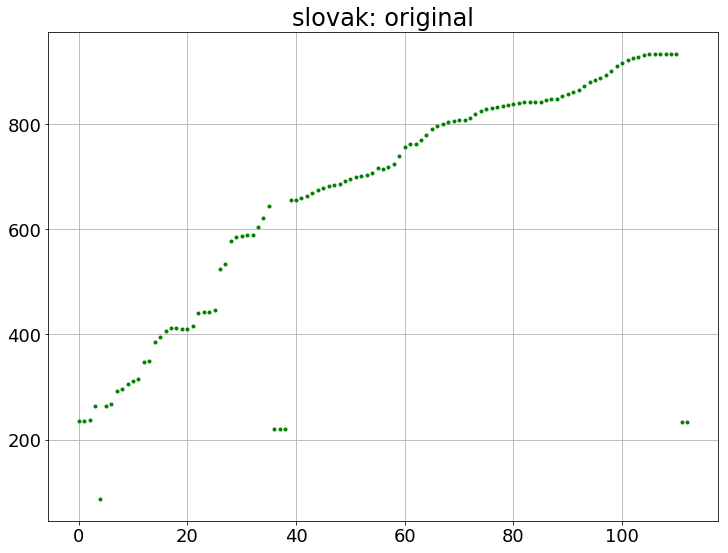

In [309]:
pitches = np.array(pitches)
fig = plt.figure(figsize=(12, 9), frameon=True)
plt.title(name + ": original", fontsize=24)
#ax = fig.add_axes([0,0,1,1])
ax = fig.gca()
ax.tick_params(labelsize=18)
ax.plot(pitches, '.g', color="green")
plt.grid()
plt.show()

In [310]:
image_path = "../output/images/%s_original.png" % name
fig.savefig(image_path, pad_inches=1, dpi=300)

In [314]:
corrected = [pitches[0]]
# first, identify all the outliers and move them closer to the correct position
for i in range(1, len(pitches)-1):
    diff = abs(pitches[i]-corrected[i-1])
    if diff > 150:
        corrected += [corrected[i-1]]
    elif diff > 100:
        average = (corrected[i-1] + pitches[i+1]) / 2
        #print(1, i, pitches[i], corrected[i-1], diff, average)
        corrected += [average]
    else:
        corrected += [pitches[i]]

In [315]:
# then iterate over the corrected array, gradually bringing the outliers into line
for x in range(2,20):
    arr = corrected
    for i in range(1, len(arr)-1):
        diff = abs(arr[i] - arr[i+1])
        threshold =100 - 5 * x
        if diff > threshold:
            average = (arr[i-1] + arr[i+1]) / 2
            #print(x, i, threshold, arr[i], corrected[i-1], diff, average)
            corrected[i] = average

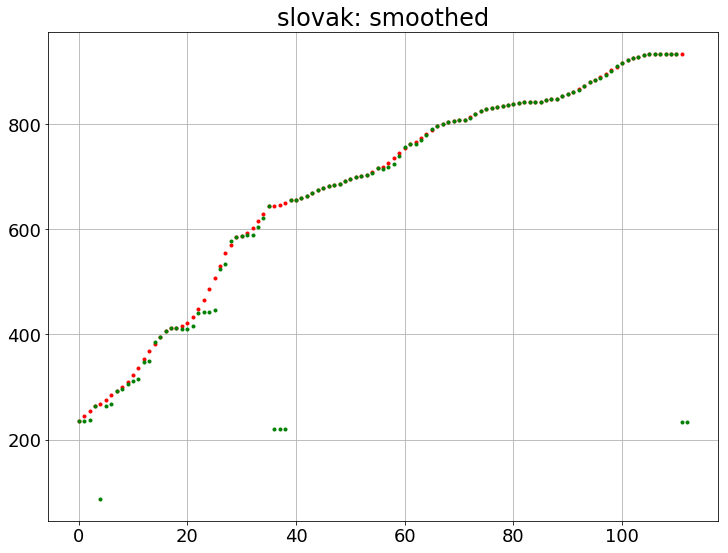

In [316]:
fig = plt.figure(figsize=(12, 9), frameon=True)
plt.title(name + ": smoothed", fontsize=24)
#ax = fig.add_axes([0,0,1,1])
ax = fig.gca()
ax.tick_params(labelsize=18)
ax.plot(corrected, '.g', color="red")
ax.plot(pitches, '.g', color="green")
plt.grid()
plt.show()

In [229]:
image_path = "../output/images/%s_smoothed.png" % name
fig.savefig(image_path, pad_inches=1, dpi=300)

In [230]:
data_path = "../output/data/%s.csv" % name

with open(data_path, "w") as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(["freq"])    
    spamwriter.writerows(map(lambda x: [x], corrected))